## Evaluating classification techniques for speaker characterization
### Laura Fernández Gallardo

Using the models trained with clean speech, analyze the effects of testing with distorted speech on the classification performance.

* WAAT classification
* multilabel classification

As done when tuning models, the evaluation metric considered is the **average per-class accuracy**.

In [1]:
import io
import requests
import pickle # save / load models
from ast import literal_eval # parsing hp of gridsearch

import numpy as np
import pandas as pd

from cls_tuning import * # my helper functions

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# fix random seed for reproducibility
seed = 2302
np.random.seed(seed)

## Features from degraded and distorted speech

**Speech degradations:** The [NSC](http://www.qu.tu-berlin.de/?id=nsc-corpus) stimuli files (shortened semi-spontaneous dialog 6) have been transmitted through 53 channel degradations (see [readme](https://github.com/laufergall/ML_Speaker_Characteristics/tree/master/data/distortions)). This makes a total of 15900 files, corresponding to 53 degradations x 300 speakers. 

**Speech distortions:** 4 packet loss and 2 jitter conditions were then applied to the 15900 files, resulting in a maximum of 4 x 2 x 15900 = 127200 files. Regrettably, about 7% of the transmission simulations were unsuccessfull (the received speech files were corrupt). Each successfully transmitted file was splitted into two and OpenSMILE speech features were [extracted](https://github.com/laufergall/ML_Speaker_Characteristics/tree/master/feature_extraction) from each of the halves. Speech features are available from a total of 235709 instances, coded by the speaker and distortions applied.  

The same set of speech features was also extracted from clean speech (all semi-spontaneous dialogs, see previous jupyter notebooks in this folder), from the 300 clean speech files corresponding to stimuli segments, and from the 15900 files of degraded stimuli segments (no packet loss or jitter conditions). 

In [3]:
# load features from clean speech

path = "https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/extracted_features/"

url = path + "/eGeMAPSv01a_semispontaneous_splitted.csv"
s = requests.get(url).content
feats_clean =pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ';') # shape: 3591, 89

# extract speaker ID and dialog number from speech file name
feats_clean['spkID'] = feats_clean['name'].str.slice(2, 5).astype('int')
feats_clean['dialog'] = feats_clean['name'].str.slice(-9,-8)

# appending class label
scores = pd.read_csv(r'..\data\generated_data\speakerIDs_cls_WAAT_all.csv') # only high/low WAAT
feats_clean_class = pd.merge(feats_clean, scores, how='inner')
feats_clean_class.head()

,name,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,...,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,spkID,dialog,gender,class
0,'m006_rabat_d5_01.wav',31.23358,0.262306,26.59388,30.09026,34.11197,7.518097,316.59510,610.79350,267.6818,...,2.643574,0.201035,0.209331,0.180400,0.286503,-30.14587,6,5,m,high
1,'m006_rabat_d5_02.wav',31.31265,0.205003,27.27562,31.13765,34.80304,7.527420,90.15386,78.50047,223.4587,...,1.550388,0.253529,0.187034,0.405807,0.462146,-30.21316,6,5,m,high
2,'m006_rabat_d5_03.wav',32.08952,0.210413,27.79275,31.72719,35.72678,7.934029,277.98860,632.48160,139.8396,...,2.132591,0.233043,0.190101,0.229767,0.381140,-29.06304,6,5,m,high
3,'m006_rabat_d6_01.wav',32.86148,0.209119,28.24504,32.85449,37.06210,8.817057,299.96070,709.52120,171.5547,...,1.770956,0.304667,0.248820,0.247241,0.419860,-27.91848,6,6,m,high
4,'m006_rabat_d6_02.wav',31.04583,0.249890,26.29376,29.80590,33.76602,7.472261,191.92640,177.29000,113.4793,...,1.890136,0.239687,0.185363,0.317407,0.477544,-29.62095,6,6,m,high


In [4]:
# load features from clean stimuli 
# used as clean condition when evaluating test performance 

# (gitignored file)
file_feats = r'..\data\extracted_features\eGeMAPSv01a_stimuli_splitted.csv'
feats_clean = pd.read_csv(file_feats, sep=';') # shape (600, 89)

# extract speaker ID from speech file name
feats_clean['spkID'] = feats_clean['name'].str.slice(2, 5).astype('int')

# distortion code
feats_clean['distnum'] = '00'

# add column with packet loss info
feats_clean['packetlossrate'] = '0'

## add column with jitter info
feats_clean['jitterms'] = '0'

In [5]:
# load features from degraded stimuli

# (gitignored file)
file_feats = r'..\data\extracted_features\eGeMAPSv01a_stimuli_splitted_degraded.csv'
feats_deg = pd.read_csv(file_feats, sep=';') # shape (31800, 89)

# extract speaker ID from speech file name
feats_deg['spkID'] = feats_deg['name'].str.slice(1, 4).astype('int')

# distortion code
feats_deg['distnum'] = feats_deg['name'].str.slice(5,7)

# add column with packet loss info
feats_deg['packetlossrate'] = '0'

## add column with jitter info
feats_deg['jitterms'] = '0'


In [6]:
# load features from degraded+distorted stimuli (packet loss and jitter)

# (gitignored file)
file_feats = r'..\data\extracted_features\eGeMAPSv01a_stimuli_splitted_distorted.csv'
feats_dist = pd.read_csv(file_feats) # shape (235709, 89)

# extract speaker ID from speech file name
feats_dist['spkID'] = feats_dist['name'].str.slice(1, 4).astype('int')

# distortion code
feats_dist['distnum'] = feats_dist['name'].str.slice(5,7)

# add column with packet loss info
feats_dist['packetlossrate'] = feats_dist['name'].str.extract('(?<=P)(.*?)(?=-)', expand=False)

## add column with jitter info
feats_dist['jitterms'] = feats_dist['name'].str.extract('(?<=J)(.*?)(?=%)', expand=False)


In [7]:
# join degraded with degraded+distorted stimuli instances
feats_dist = feats_dist.append(feats_deg) # shape (267509, 93)

# join degraded and degraded+distorted with clean stimuli instances
feats_dist = feats_dist.append(feats_clean) # shape (268109, 93)

In [9]:
# load mapping of degradation names
path = "https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/distortions/"
url = path + "dist_mapping.csv"
s = requests.get(url).content
dist_mapping =pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ';')

# padding distortion codes with zeroes
dist_mapping['distnum'] = dist_mapping['distnum'].astype(str).str.zfill(2)

# merge feats with distmapping to know name of distortions
feats_dist = feats_dist.merge(dist_mapping)

# appending class label
feats_dist_class = pd.merge(feats_dist, scores, how='inner')

In [10]:
# how many degradations
print(feats_dist['distcode'].value_counts().mean()) # around 5000 instances for each degradation
print(len(feats_dist['distcode'].value_counts())) # 53 degradations
print(feats_dist['packetlossrate'].value_counts()) # around 30K instances for each packet loss rate * 2 jitter conditions

4964.981481481482
54
1     61382
3     59997
5     58761
10    55569
0     32400
Name: packetlossrate, dtype: int64


## WAAT classification

The WAAT (warmth-attractiveness) score distribution was already explored in Part I.

This notebook: binary classification with data partitions:

* train: clean speech data from semi-spontaneous dialogs: 5, 7, and 8.
* test: degraded/distorted data from NSC stimuli (shortened semi-spontaneous dialog 6). 

(different from the splitting speakers strategy of Part I).

In [11]:
# train data
dialogs_train = ['5', '7', '8']
feats_clean_class_train = feats_clean_class.loc[feats_clean_class['dialog'].isin(dialogs_train)] # shape (1647, 93)

# test data: each degradation / distortion in feats_dist_class

### Model tuning

Pick the classifiers that worked best in Part I and tune with train data folling the same approach for nested hp tuning.

In [12]:
# Standardize speech features  

# learn transformation on training data
scaler = StandardScaler()
scaler.fit(feats_clean_class_train.drop(['name','spkID','dialog','gender','class'],axis=1))

# numpy n_instances x n_feats
feats_s_train = scaler.transform(feats_clean_class_train.drop(['name','spkID','dialog','gender','class'],axis=1))

In [13]:
# training data. Features and labels
X = feats_s_train
y = feats_clean_class_train['class'].astype('category').cat.codes

feats_clean_class_train['genderclass']= feats_clean_class_train[['gender', 'class']].apply(lambda x: ''.join(x), axis=1)

feats_names = pd.read_csv(r'.\data_while_tuning\feats_names.csv', header = None)
feats_names = feats_names.values.tolist()

D:\Users\fernandez.laura\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [14]:
# split train data into 80% and 20% subsets - with balance in trait and gender
# give subset A to the inner hyperparameter tuner
# and hold out subset B for meta-evaluation


AX, BX, Ay, By = train_test_split(X, y, test_size=0.20, stratify = feats_clean_class_train['genderclass'], random_state=2302)

print('Number of instances in A (hyperparameter tuning):',AX.shape[0])
print('Number of instances in B (meta-evaluation):',BX.shape[0])

Number of instances in A (hyperparameter tuning): 1317
Number of instances in B (meta-evaluation): 330


In [15]:
# dataframe with results from hp tuner to be appended
tuning_all = pd.DataFrame()

# list with tuned classifiers trained on training data, to be appended
trained_all = []

In [16]:
from sklearn.neighbors import KNeighborsClassifier

"""
K Nearest Neighbors
"""
def get_KNeighborsClassifier2tune():

    model = KNeighborsClassifier()
    hp = dict(
        classifier__n_neighbors = [1] #list(range(1,20))
    )
    return 'KNeighborsClassifier_clean', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_KNeighborsClassifier2tune], feats_names)

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'KNeighborsClassifier_clean' -> Best cross-val score on A set: 0.872616 using {'classifier__n_neighbors': 1, 'selecter__k': 87}
'KNeighborsClassifier_clean' -> Selected features: ["'F0semitoneFrom27.5Hz_sma3nz_amean'"]
'KNeighborsClassifier_clean' -> Average per-class accuracy on B set: 0.825367



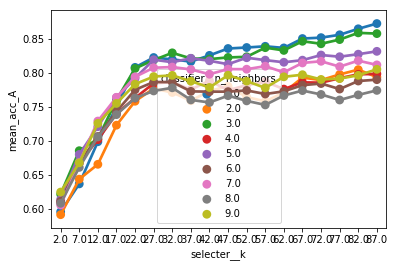

In [12]:
# open generated file with results of fitting GridSearchCV
 
sgrid = pd.read_csv(r'.\data_while_tuning\KNeighborsClassifier_clean_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
params_df = params_df.loc[params_df['classifier__n_neighbors']<10,:] # selecting only lower k
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__n_neighbors', data=sgrid.join(params_df)) 

### Testing across channel degradations and distortions

In [17]:
# select the classifier that gave the maximum acc on B set
best_accs = tuning_all['best_accs']
i_best = best_accs.idxmax()

print('Selected classifier based on the best performance on B: %r (accB = %0.2f)' % (tuning_all.loc[i_best,'classifiers_names'], round(best_accs[i_best],2)))

Selected classifier based on the best performance on B: 'KNeighborsClassifier_clean' (accB = 0.83)


In [26]:
dist_codes = dist_mapping['distcode']
packetlossrate_codes = feats_dist_class['packetlossrate'].unique()
jitterms_codes = feats_dist_class['jitterms'].unique()

test_performance = pd.DataFrame() # append results for each condition


# loop over each degradations / distortions in feats_dist_class

for i in np.arange(0,len(dist_codes)):
    for j in np.arange(0,len(packetlossrate_codes)):
        for k in np.arange(0,len(jitterms_codes)):

            # selecting features of one condition given by i, j, k
            cond1 = feats_dist_class['distcode']==dist_codes[i] 
            cond2 = feats_dist_class['packetlossrate']==packetlossrate_codes[j] 
            cond3 = feats_dist_class['jitterms']==jitterms_codes[k] 
            feats_cond_class = feats_dist_class.loc[cond1 & cond2 & cond3]

            if feats_cond_class.shape[0] > 0:
            
                # scaling test features with the transformation learnt in training
                dropcolumns=['name','spkID','distnum','packetlossrate','jitterms','distcode','gender','class']
                feats_s_test = scaler.transform(feats_cond_class.drop(dropcolumns,axis=1)) 

                # test data. Features and labels
                Xt = feats_s_test
                yt = feats_cond_class['class'].astype('category').cat.codes

                # predictions on the test set 
                # feat sel on Xt is performed by the classifier
                yt_pred = trained_all[i_best][0].predict(Xt)

                recallscore = recall_score(yt, yt_pred, average='macro')
                
                # create the output dataframe
                d = {
                    'degradation': dist_codes[i],
                    'packetlossrate': packetlossrate_codes[j],
                    'jitterms': jitterms_codes[k],
                    'average per-class accuracy': round(float(recallscore),2),
                }
                res = pd.DataFrame(data = d, index=[0])

                test_performance = test_performance.append(res, ignore_index=True)

In [35]:
test_performance['distortion']= test_performance[['packetlossrate', 'jitterms']].apply(lambda x: 'P'+x[0].zfill(2)+'J'+x[1].zfill(2), axis=1)

test_performance.to_csv(r'.\performance_channels\cls_test_distortionsdegradations_'+tuning_all.loc[i_best,'classifiers_names']+'.csv', index=False)

In [2]:
test_performance = pd.read_csv(r'.\performance_channels\cls_test_distortionsdegradations_KNeighborsClassifier_clean.csv')

In [3]:
testacc_clean = test_performance.loc[test_performance['degradation']=='Clean','average per-class accuracy']
testacc_clean

0    0.6
Name: average per-class accuracy, dtype: float64

In [36]:
test_performance['bandwidth']=test_performance['degradation'].str.slice(0,2)

test_performance['codec'] = test_performance['degradation'].str.extract('(?<=B_)(.*?)(?=_)', expand=False)


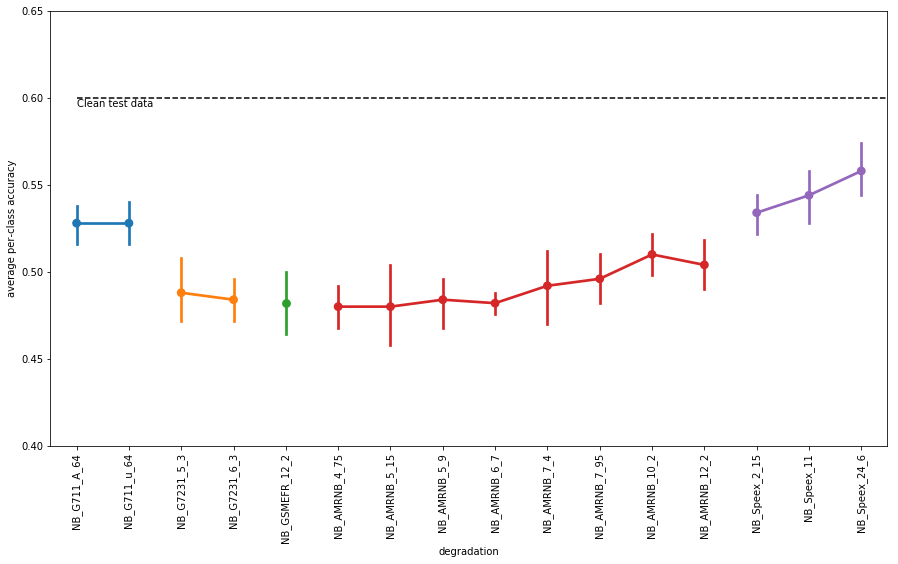

In [39]:
# visualize performance across NB degradations and distortions

fig, ax = plt.subplots(figsize=[15, 8])

# data to plot
mdata = test_performance[test_performance['bandwidth']=='NB']
mdata = mdata[mdata['jitterms']==0]
ndegs = len(mdata['degradation'].unique())

# pointplot
myfig = sns.pointplot(
    x='degradation', 
    y='average per-class accuracy',
    hue='codec', # distortion
    data=mdata
) 

# add dashed line indicating test performance with clean data
plt.plot(np.linspace(0,ndegs,1000), [testacc_clean]*1000, 'k--')
plt.text(0, testacc_clean-0.005, 'Clean test data')
        
# rotate x axis and limit y axis
for item in myfig.get_xticklabels():
    item.set_rotation(90)
plt.ylim(0.40, 0.65)
    
ax.legend_.remove()

# filename = r'\cls_test_distortionsdegradations_'+tuning_all.loc[i_best,'classifiers_names']+'_NB_J00ms.png'
# myfig.get_figure().savefig(r'.\figures' + filename, bbox_inches = 'tight')    

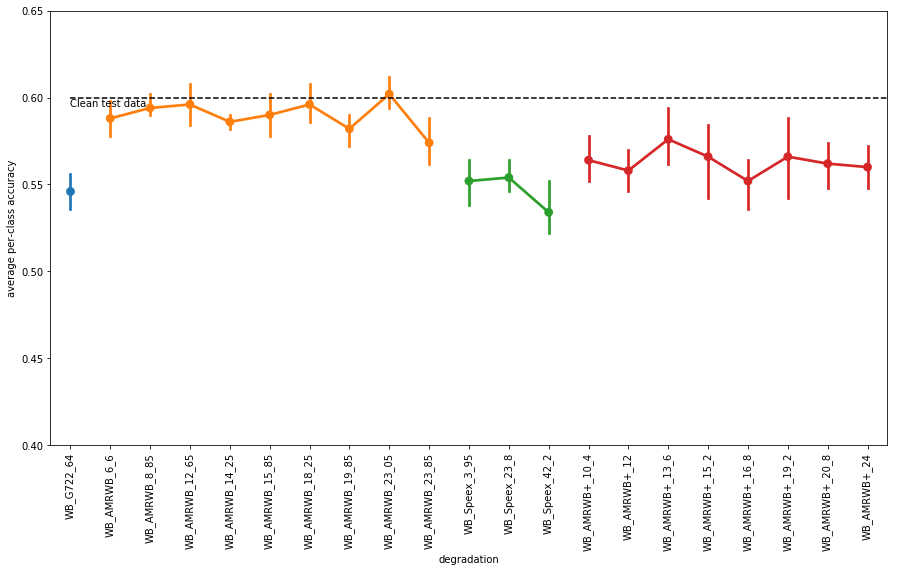

In [40]:
# visualize performance across WB degradations and distortions

fig, ax = plt.subplots(figsize=[15, 8])

# data to plot
mdata = test_performance[test_performance['bandwidth']=='WB']
mdata = mdata[mdata['jitterms']==0]
ndegs = len(mdata['degradation'].unique())

# pointplot
myfig = sns.pointplot(
    x='degradation', 
    y='average per-class accuracy',
    hue='codec', # distortion
    data=mdata
) 

# add dashed line indicating test performance with clean data
plt.plot(np.linspace(0,ndegs,1000), [testacc_clean]*1000, 'k--')
plt.text(0, testacc_clean-0.005, 'Clean test data')
        
# rotate x axis and limit y axis
for item in myfig.get_xticklabels():
    item.set_rotation(90)
plt.ylim(0.40, 0.65)

ax.legend_.remove()

# filename = '\cls_test_distortionsdegradations_'+tuning_all.loc[i_best,'classifiers_names']+'_WB_J00ms.png'
# myfig.get_figure().savefig(r'.\figures' + filename, bbox_inches = 'tight')  

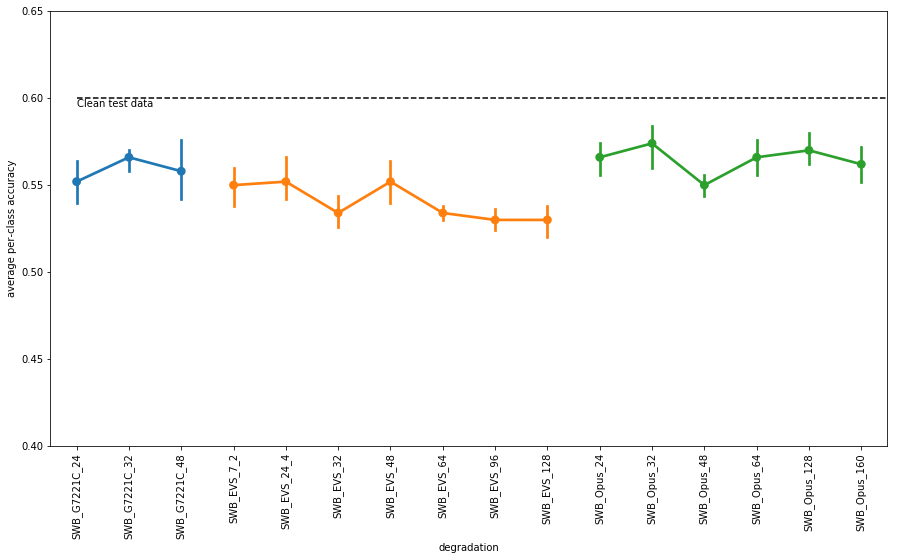

In [41]:
# visualize performance across SWB degradations and distortions

fig, ax = plt.subplots(figsize=[15, 8])

# data to plot
mdata = test_performance[test_performance['bandwidth']=='SW']
mdata = mdata[mdata['jitterms']==0]
ndegs = len(mdata['degradation'].unique())

# pointplot
myfig = sns.pointplot(
    x='degradation', 
    y='average per-class accuracy',
    hue='codec', # distortion
    data=mdata
) 

# add dashed line indicating test performance with clean data
plt.plot(np.linspace(0,ndegs,1000), [testacc_clean]*1000, 'k--')
plt.text(0, testacc_clean-0.005, 'Clean test data')

# rotate x axis and limit y axis
for item in myfig.get_xticklabels():
    item.set_rotation(90)
plt.ylim(0.40, 0.65)

ax.legend_.remove()

# filename = '\cls_test_distortionsdegradations_'+tuning_all.loc[i_best,'classifiers_names']+'_SWB_J00ms.png'
# myfig.get_figure().savefig(r'.\figures' + filename, bbox_inches = 'tight')  

In view of these plots, it seems that:

* The performance with a hold-out of training data was 0.83 and it drops to 0.6 (clean data) for some reason.
* The performance in NB is worse than that in WB and in SWB, which indicates the influence of transmission bandwidth.
* Incresing bitrate seems to lead to better performance in NB, yet this was not observed in WB or SWB.
* Only some WB conditions offer equal or better performance compared to that offered by clean test speech. 
* There is no clear tendency that higher packet loss rates affect the performance.


TODO:
    
* how to improve the clean performance of 0.60?     
    * tune and test other classifiers
    * different train/test configuration?
* evaluate possible influence of jitter